# 1- Introduction

In this notebook, we will demonstrate how to use the akward table and how to build selector efficiently using lambda's in python

In [294]:
import uproot
import awkward as ak
import numpy as np
import math
import hist
import matplotlib.pyplot as plt
import os
import subprocess
import vector
import gc

First we need to identify the akward table as vectors

In [295]:
vector.register_awkward() 

We then collect the data (either MC or real data)

In [296]:
DATATYPE="mc"
assert((DATATYPE=="mc") or (DATATYPE=="data"))
BASEDIR="/pbs/throng/training/nantes-m2-rps-exp/data" # basedir where to look for runXXX.DATATYPE.root files
IS_MC=True if DATATYPE=="mc" else False

In [297]:
def data_file_path(run,is_mc=IS_MC,dest=BASEDIR):
    datatype="mc" if is_mc else "data"
    print({dest},"/run",{run},".",{datatype},".root")
    return f"{dest}/run{run}.{datatype}.root"

In [298]:
SAMPLE_RUNS=[291694,291399]

Let's now open the root file and print the content

In [299]:
file = uproot.open(data_file_path(SAMPLE_RUNS[0],IS_MC))
events = file["eventsTree"]
eventsGen = file["genTree"]
events.show()
eventsGen.show()

{'/pbs/throng/training/nantes-m2-rps-exp/data'} /run {291694} . {'mc'} .root
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
runNumber            | int32_t                  | AsDtype('>i4')
xVtx                 | double                   | AsDtype('>f8')
yVtx                 | double                   | AsDtype('>f8')
zVtx                 | double                   | AsDtype('>f8')
isCINT               | bool                     | AsDtype('bool')
isCMSL               | bool                     | AsDtype('bool')
isCMSH               | bool                     | AsDtype('bool')
isCMLL               | bool                     | AsDtype('bool')
isCMUL               | bool                     | AsDtype('bool')
nMuons               | int32_t                  | AsDtype('>i4')
Muon_E               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_Px              | st

We will just print here the number of entries (events) in the file for the record

In [300]:
print(events.num_entries)
print(eventsGen.num_entries)

40000
40000


# 2- 4-momentum vector with akward and selectors

It is possible to build akward table as a 4-momentum vector. To do that, you need to use the "zip" method whith px, py, pz and E as its 4 first members. You also need to call this table with the following specific name "Momentum4D"

This allow you in the following to get the kinematics of your tracks quite easily by calling:
- .p, .px, .py, .pz, .pt, ... for the momentum
- .eta for the pseudo-rapidity
- ...

Indeed, you can also add more information to the akward table after defining the first 4 members of the table (as you can see below)

We are here implementing a "getTracks" function that will be use in the following to select tracks. See here:

In [301]:
def getTracks(events):
    return ak.zip({"px":events["Muon_Px"],
                       "py":events["Muon_Py"],
                       "pz":events["Muon_Pz"],
                       "E":events["Muon_E"],
                       "charge":events["Muon_Charge"],
                       "thetaAbs":events["Muon_thetaAbs"],
                       "matched":events["Muon_matchedTrgThreshold"],
                       "n":events["nMuons"]},
                    with_name='Momentum4D')

def getTracksGen(events):
    return ak.zip({"px":events["Muon_GenPx"],
                    "py":events["Muon_GenPy"],
                    "pz":events["Muon_GenPz"],
                    "E":events["Muon_GenE"],
                    "n":events["nMuonsGen"],
                    "label":events["Muon_GenLabel"],
                    "mother":events["Muon_GenMotherPDGCode"]},
                    with_name='Momentum4D')

Now we will design a function to run over the data with uproot. 
In the iterate, we define all the varaible we want to access for each events

We first select good events and track using lambdas in python. What is a good event or a good track will be define later when we call the function "scan"

In [302]:
#########
# My code
#########

def invariant_mass(pT1,pT2,eta1,eta2,phi1,phi2):
    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))

#def invariant_mass(E1,E2,p1,p2):
#    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))

def combinations(x):
    idx = np.stack(np.triu_indices(len(x), k=1), axis=-1)
    return x[idx]
combinations(np.arange(3))


array([[0, 1],
       [0, 2],
       [1, 2]])

In [303]:
print(dir(vector.backends.awkward.MomentumArray4D))

['E', 'E2', 'Et', 'Et2', 'GenericClass', 'M', 'M2', 'Mask', 'Mt', 'Mt2', 'ProjectionClass2D', 'ProjectionClass3D', 'ProjectionClass4D', '__abs__', '__abstractmethods__', '__add__', '__and__', '__annotations__', '__array__', '__array_function__', '__array_ufunc__', '__arrow_array__', '__bool__', '__bytes__', '__cast_cpp__', '__class__', '__class_getitem__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__divmod__', '__doc__', '__eq__', '__floordiv__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__init__', '__init_subclass__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift__', '__lt__', '__matmul__', '__mod__', '__module__', '__mul__', '__ne__', '__neg__', '__new__', '__or__', '__pos__', '__pow__', '__radd__', '__rand__'

In [304]:
import pandas
l1 = pandas.read_csv('../data/counters.offline.csv')['run']
l2 = [int(e) for e in os.popen("ls /pbs/throng/training/nantes-m2-rps-exp/data/ | grep 'mc' | cut -c 4-9").read().split('\n')[0:-2]]
#list(set(l1) & set(l2))

In [305]:
def invariant_mass(part1,part2):
    # sum impulsions
    px = part1.px+part2.px
    py = part1.py+part2.py
    pz = part1.pz+part2.pz 
    E1 = part1.e
    E2 = part2.e
    return np.sqrt((E1+E2)**2-(px**2+py**2+pz**2))

In [368]:
def scanGen(dataDescription, 
              #hMag:hist.Hist, hPhi:hist.Hist, hMinv:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    
    for batch in uproot.iterate(dataDescription,
                                ["nMuonsGen","Muon_GenPx","Muon_GenPy","Muon_GenPz","Muon_GenE","Muon_GenLabel","Muon_GenMotherPDGCode"],                                
                                 report=True):

        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        tracks = getTracksGen(events)
        goodTracks=tracks[trackSelector(tracks)]
        t = goodTracks  # notation
         
        # JPsi 443
        
        print(t)
        
        NgenJPsi = ak.sum(1*t.mother==443)/2
        NgenJPsiN = NgenJPsi/len(t)
        
        if verbose:
            print(batch[1])
        gc.collect()

        return NgenJPsiN



In [369]:
# Ordre de grandeur
#Aeps = 0.2386
#sigmaJPsi = Nraw*A/(Aeps*5.94)

In [370]:
def scan(dataDescription, 
              hMag:hist.Hist, hPhi:hist.Hist, hMinv:hist.Hist,
              eventSelector=lambda x:[True]*len(x),
              trackSelector=lambda x:[True]*len(x), 
              verbose:bool=False):
    """ Loop over data to fill the invariant mass histogram.
        
        :param: dataDescription: is anything uproot.iterate can take.
                typical something like run*.data.root:eventsTree in our case
        :param: eventSelector: returns an array of bool from an array of events
        :param: trackSelector: returns an array of bool from an array of tracks
    """
    


    
    for batch in uproot.iterate(dataDescription,
                                ["isCINT","isCMUL","isCMSL","nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_E","Muon_Charge","Muon_thetaAbs","Muon_matchedTrgThreshold"],                                
                                 report=True):
        events=batch[0] # batch[1] is the report info
        if len(events) < 1000:
            print("something is wrong",batch[1]) # this is a protection for some corrupted input data files 
            break
            
        goodEvents = events[eventSelector(events)] 
        tracks = getTracks(events)
        goodTracks=tracks[trackSelector(tracks)]
        t = goodTracks  # notation
         
        #hMag.fill(ak.flatten(t.p))
        #hPhi.fill(ak.flatten(t.phi))

        # Keep events with n>=2
        n = ak.num(t.charge,axis=1)
        tsel = t[n==2]
        
        # Combinations
        C = ak.combinations(tsel,2)
        
        # Keep opposite charges only    
        I = (C["0"].charge+C["1"].charge)==0
        
        # Compute invariant mass
        
        minv = invariant_mass(C["0"][I],C["1"][I])
        
        hMinv.fill(ak.flatten(minv))
        
        # Simple integral
        Nraw = ak.sum(1*(2.7<minv)*(minv<3.4))
        
        # JPsi: 100140, Psi2s: 49860
        #print("A.eps=",(Nraw/len(events))/(100140/150000))
        #print(ak.sum([]))
        
        NrawN = Nraw/len(events)
        
        #print(C["0"])
        #print(len(C),len(Csel))
        #Ccharge = ak.combinations(tsel.charge,2)
        #print((ak.to_layout(Ccharge)[0][0]))
        #print(ak.sum(Ccharge,axis=1))
        #print(C)
        #print(ak.num(tsel,axis=1))
        
        
        
        #invariant_mass(E1,E2,p1,p2)
        #hMinv
        #print(type(goodTracks))
        #print(dir(vector.backends.awkward.MomentumArray4D))
        #print((goodTracks.p))
        
        
        
        if verbose:
            print(batch[1])
        gc.collect()
                    
        return NrawN



We define now some histograms that we want to plot and run over the data. We do it twice for illustration purposes:
- first, we don't give any definition for the eventselector and track selector. This is equivalent to say that all events and all tracks are good
- second, we implement some definition for the lambda function to have some selection criteria on our tracks


In [371]:
%%time
## SINGLE MUON TRACK PLOTS
#No cuts
vhMagRaw = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiRaw = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))
#Event selection
vhMagEvSel = hist.Hist(hist.axis.Regular(bins=100,start=0,stop=100,name='$|p|$'))
vhPhiEvSel = hist.Hist(hist.axis.Regular(bins=200,start=-22/7,stop=22/7,name='$\phi$'))

vhMinvEvSel = hist.Hist(hist.axis.Regular(bins=200,start=1,stop=5.5,name='$m\mu\mu$'))

#scan(dataDescription=f"{BASEDIR}/run*.{DATATYPE}.root:eventsTree",
#          hMag=vhMagRaw, hPhi=vhPhiRaw)


NgenN = scanGen(dataDescription=f"{BASEDIR}/run291694.mc.root:genTree",
          #hMag=vhMagEvSel, hPhi=vhPhiEvSel, hMinv=vhMinvEvSel,
          #eventSelector=lambda x: x["isCMUL"]==True,
          #trackSelector=lambda x: (x.p>5) & (x.eta>-4),
         verbose=True
    )

NrawN = scan(dataDescription=f"{BASEDIR}/run291694.mc.root:eventsTree",
          hMag=vhMagEvSel, hPhi=vhPhiEvSel, hMinv=vhMinvEvSel,
          #eventSelector=lambda x: x["isCMUL"]==True,
          #trackSelector=lambda x: (x.p>5) & (x.eta>-4),
         verbose=True
    )

print(NrawN/NgenN)

[[{px: 1.4, py: -0.226, pz: -10.2, E: 10.3, n: 2, label: 1, ...}, ...], ...]
<Report start=0 stop=40000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291694.mc.root:/genTree;1'>
<Report start=0 stop=40000 source='/pbs/throng/training/nantes-m2-rps-exp/data/run291694.mc.root:/eventsTree;1'>
0.2602272301173647
CPU times: user 798 ms, sys: 311 µs, total: 798 ms
Wall time: 799 ms


We can now plot the results! See from the plots that our selection removed some entries in all histograms

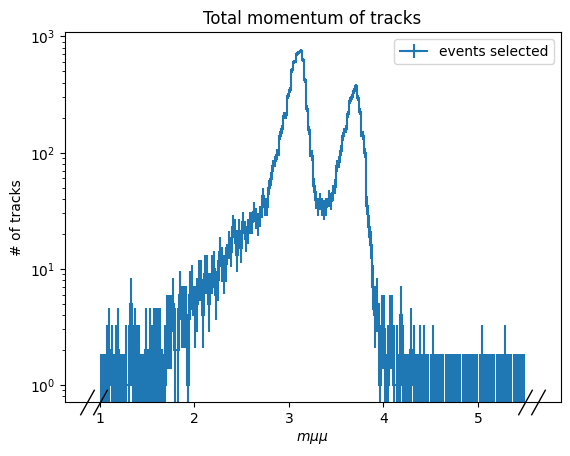

In [310]:
#vhMagRaw.plot(label="no cuts")
vhMinvEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Total momentum of tracks');
plt.legend();

/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_187/3845830240.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


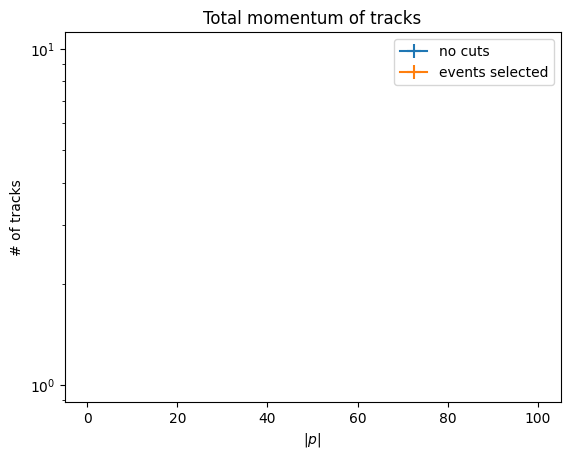

In [311]:
vhMagRaw.plot(label="no cuts")
vhMagEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Total momentum of tracks');
plt.legend();


/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/pbs/throng/training/nantes-m2-rps-exp/miniconda3/envs/qqbar2mumu/lib/python3.9/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/tmp/ipykernel_187/1091764743.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


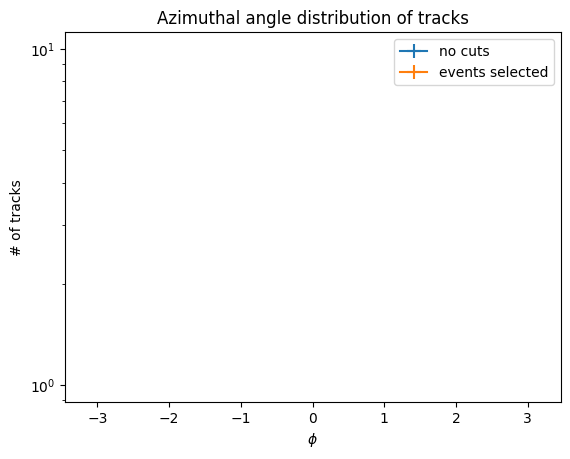

In [312]:
vhPhiRaw.plot(label="no cuts")
vhPhiEvSel.plot(label="events selected")
plt.yscale("log")
plt.ylabel("# of tracks")
plt.title('Azimuthal angle distribution of tracks');
plt.legend();